In [1]:
import os
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
parent_dir = '/home/jovyan/work/Test'
anno_dir = "chips_positive_xml"
img_ids = "img_ids.txt"

x


(0.0, 160.0)

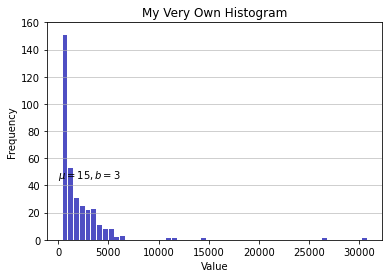

In [217]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=area_dict["undefined_object"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [214]:
#fix truncated/difficult after updating corrected labels 
def area_dist(parent_dir, img_ids, anno_dir, keep_difficult = True, bbox_remove = 10):       
    """
    for each img, parse the annotations in a format readable for pytorch
    argument: the parent directory and subdirectory containing the image; the imageid for the image of interest; the label map
    returns: a dictionary containing the bounding boxes, labels, and difficults
    """
    with open(os.path.join(parent_dir, img_ids)) as f:
        ids = f.read().splitlines()

    #Initial variables to count the number of objects in each category (set to zero)
    area_dict = {"closed_roof_tank": [], "narrow_closed_roof_tank": [], "external_floating_roof_tank": [], "spherical_tank":[], 
                 "sedimentation_tank":[], "water_tower": [], "undefined_object": []}
    for id in ids:
        tree = et.parse(os.path.join(parent_dir, anno_dir, id +".xml"))
        root = tree.getroot()
        for object in root.iter('object'):
            bbox = object.find('bndbox')
            xmax = float(bbox.find('xmax').text)
            xmin = float(bbox.find('xmin').text)
            width = xmax - xmin
            ymax = float(bbox.find('ymax').text)
            ymin = float(bbox.find('ymin').text)
            height = ymax - ymin
            object.find('bndbox')
            area = width * height
            #remove_bbox = (xmax == xmin) | (ymax == ymin) | ((width <= bbox_remove) & (height <= bbox_remove))
            remove_bbox = (xmax == xmin) | (ymax == ymin) | (area < bbox_remove**2) 
            if remove_bbox:
                #print("remove small")
                continue
            elif (object.find('truncated').text == "1") & (not keep_difficult):
                #print("remove truncated")
                continue
            elif (object.find('difficult').text == "1") & (not keep_difficult):
                #print("remove difficult")
                continue
            elif object.find("name").text in area_dict:
                area_dict[object.find("name").text].append(area)
    return area_dict

In [ ]:
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
        self.areaRngLbl = ['all', 'small', 'medium', 'large']

True 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


10.0
False 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


10.0
False 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


100.0
False 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


400.0


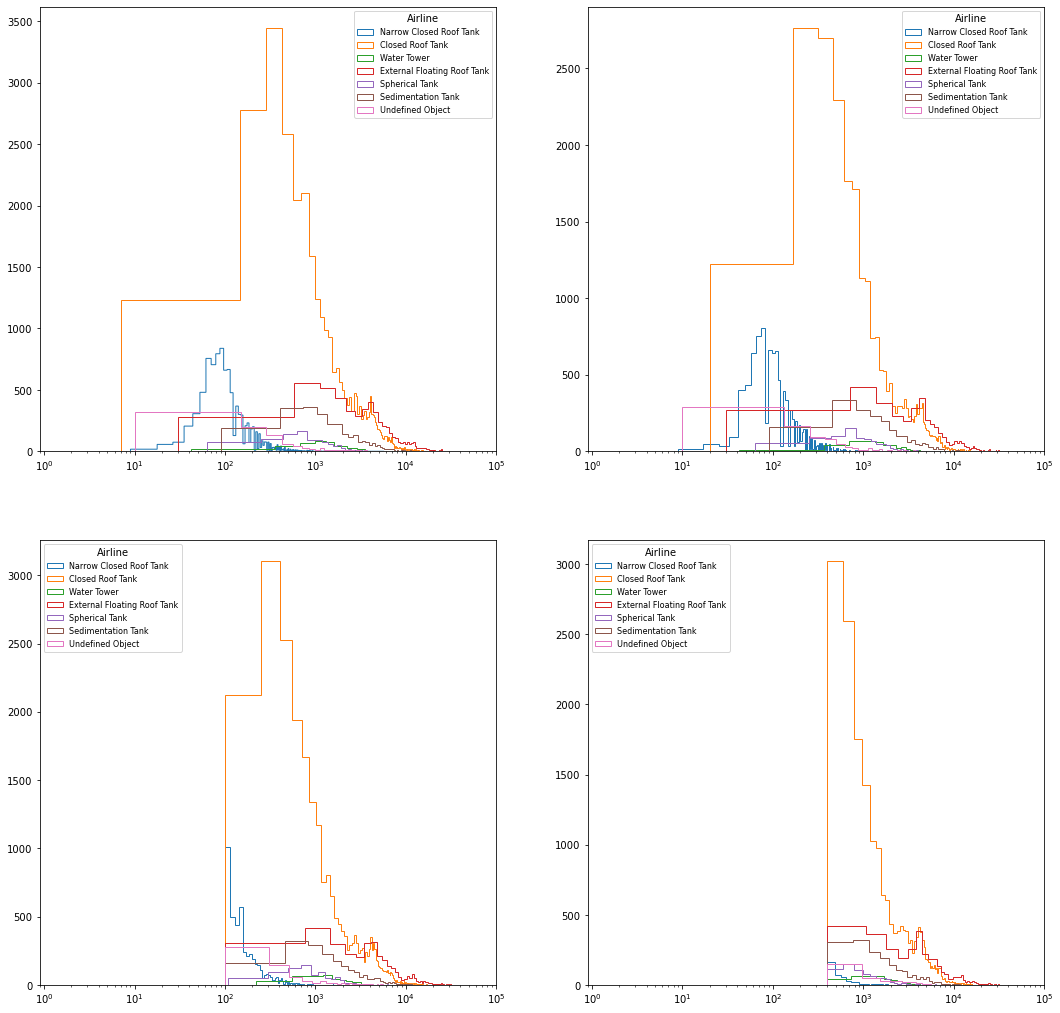

In [229]:
# Find IDs of images for subset
keep_difficult_input = [True,False,False,False]
box_remove_input = [0,0,10,20]

names = ['Keep difficult objects and all objects', "Remove difficult objects", 
         "Remove difficult objects and bounding boxes less than 10**2 in area", "Remove difficult objects and bounding boxes 20**2"]

fig, axes = plt.subplots(2,2, figsize=(18,18))
counter = 0
for name, ax in zip(names, axes.flatten()):
    print(keep_difficult_input[counter], box_remove_input[counter])
    area_dict = area_dist(parent_dir, img_ids, anno_dir, keep_difficult = keep_difficult_input[counter], bbox_remove = box_remove_input[counter])
    # Draw the density plot
    ax.set_xscale('log')
    ax.set_xlim(0,100000)
    print(min(area_dict["undefined_object"]))
    ax.hist(area_dict["narrow_closed_roof_tank"],  bins='auto', stacked=True,fill=False,histtype='step', label = "Narrow Closed Roof Tank")
    ax.hist(area_dict["closed_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Closed Roof Tank")  
                           
    ax.hist(area_dict["water_tower"],  bins='auto', stacked=True, fill=False,  histtype='step' ,label = "Water Tower")  
                           
    ax.hist(area_dict["external_floating_roof_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "External Floating Roof Tank") 
                           
    ax.hist(area_dict["spherical_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Spherical Tank") 
                           
    ax.hist(area_dict["sedimentation_tank"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Sedimentation Tank")             
    ax.hist(area_dict["undefined_object"],  bins='auto', stacked=True, fill=False, histtype='step', label = "Undefined Object")  
    # Plot formatting
    ax.legend(prop={'size': 8}, title = 'Airline')
    counter += 1
plt.show()